# How to Structure from Motion

## Authors: Muneeb Aadil, Sibt Ul Hussain

In [17]:
## Help: https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_calib3d/py_epipolar_geometry/py_epipolar_geometry.html
#loading needed libraries 
import utils as ut 
import SfM as sfmnp

import matplotlib.pyplot as plt 
%matplotlib notebook 
from mpl_toolkits.mplot3d import Axes3D

import cv2 
import numpy as np 

#auto-reloading external modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Chapter 1. Prerequisites

## 1.1. Transformations

## 1.2. Camera Models 

## 1.3 RANSAC

# Chapter 2. Epipolar Geometry

## 2.0. Reading a pair of images, and comparing SIFT matches

<IPython.core.display.Javascript object>


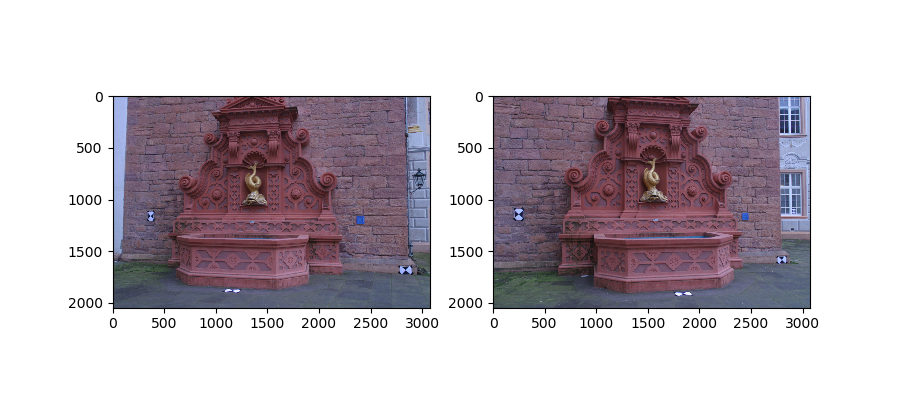

In [20]:
#Reading two images for reference
img1 = cv2.imread('../data/fountain-P11/images/0004.jpg')
img2 = cv2.imread('../data/fountain-P11/images/0006.jpg')

#Converting from BGR to RGB format
img1 = img1[:,:,::-1]
img2 = img2[:,:,::-1]

#NOTE: you can adjust appropriate figure size according to the size of your screen
fig,ax=plt.subplots(ncols=2,figsize=(9,4)) 
ax[0].imshow(img1)
ax[1].imshow(img2)

In [21]:
#Getting SIFT/SURF features for image matching (this might take a while)
kp1,desc1,kp2,desc2,matches=ut.GetImageMatches(img1,img2)

#Aligning two keypoint vectors
img1pts,img2pts,img1idx,img2idx=ut.GetAlignedMatches(kp1,desc1,kp2,desc2,matches)

## 2.2. Fundamental Matrix Computation

### 2.2.1. Eight Point Algorithm

In [22]:
img1pts_, img2pts_ = img1pts[:8], img2pts[:8]
Fgt, mask = cv2.findFundamentalMat(img1pts_,img2pts_,method=cv2.FM_8POINT)
F = sfmnp.EstimateFundamentalMatrix(img1pts_,img2pts_)

In [23]:
print ("Fundamental matrix",F) 
print 
print ("Fundamental matrix sfm",Fgt)
np.testing.assert_allclose(F, Fgt, rtol=1e-7,atol=1e-3)

Fundamental matrix [[-4.14372595e-08  8.28715212e-08 -8.43625823e-05]
 [ 4.15072787e-07  2.95698948e-08  2.97788200e-03]
 [-3.31657099e-04 -3.91844172e-03  1.00000000e+00]]
Fundamental matrix sfm [[-5.97892969e-09  7.76025698e-08 -1.20887915e-04]
 [ 3.84560269e-07  2.73818759e-08  2.75620056e-03]
 [-3.63233286e-04 -3.62885238e-03  1.00000000e+00]]


### 2.2.2. Normalized 8 Point Algorithm

In [24]:
F_normalized = sfmnp.EstimateFundamentalMatrixNormalized(img1pts_,img2pts_)
print(F_normalized)

[[-1.16698430e-08  2.33388418e-08 -3.75407186e-05]
 [ 1.16895623e-07  8.32767503e-09  1.03555329e-03]
 [-4.84161813e-05 -9.13824888e-04  7.64261843e-01]]


### 2.2.3. with RANSAC (Random Sample Consensus)

In [25]:
Fgt, maskgt = cv2.findFundamentalMat(img1pts,img2pts,method=cv2.FM_RANSAC,)
maskgt = maskgt.astype(bool).flatten()

F, mask = sfmnp.EstimateFundamentalMatrixRANSAC(img1pts,img2pts,.1,iters=20000)

In [26]:
print (Fgt )
print 
print (F)

np.testing.assert_allclose(F,Fgt,rtol=1e-7,atol=1e-3)

[[-7.81818018e-09  1.16620400e-07 -1.75262208e-04]
 [ 3.42813088e-07  1.64778335e-08  2.80101788e-03]
 [-3.02277699e-04 -3.65923057e-03  1.00000000e+00]]
[[ 7.48797442e-10 -1.02269778e-07  1.22122816e-04]
 [ 5.71541260e-07  2.17746150e-08  2.52396713e-03]
 [-6.31560206e-04 -3.38247542e-03  1.00000000e+00]]


## 2.2. Epipolar Lines Computation

In [27]:
lines2=sfmnp.ComputeEpiline(img1pts[mask],1,F)
lines1=sfmnp.ComputeEpiline(img2pts[mask],2,F)

## 2.3. Epipoles Computation

In [28]:
#to do later..

## 2.4. Visualizations I: Epipolar Geometry
### 2.4.1. Epipolar Lines

<IPython.core.display.Javascript object>


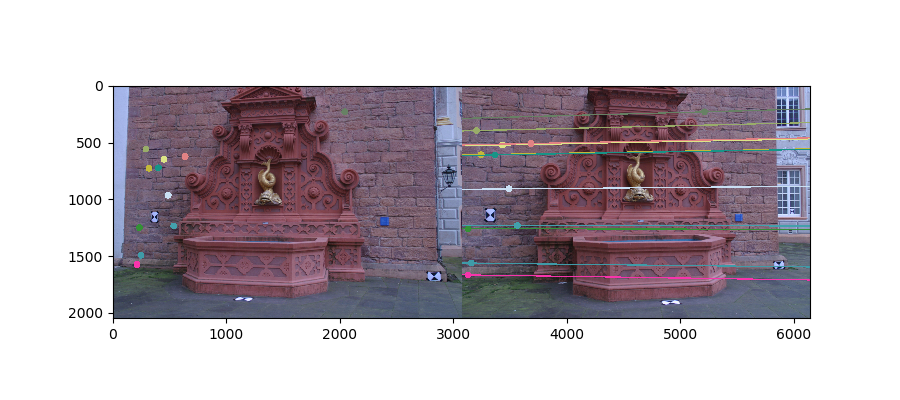

<IPython.core.display.Javascript object>


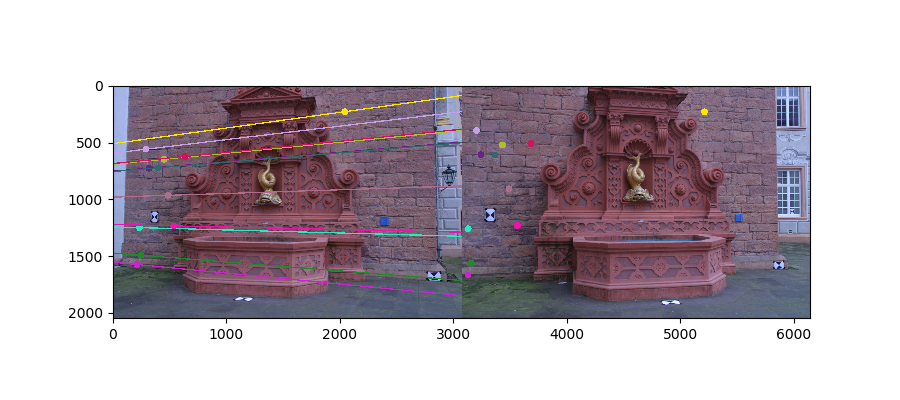

In [29]:
tup = ut.drawlines(img2,img1,lines2,img2pts[mask],img1pts[mask],drawOnly=10,
                   linesize=10,circlesize=30)
epilines2 = np.concatenate(tup[::-1],axis=1) #reversing the order of left and right images

plt.figure(figsize=(9,4))
plt.imshow(epilines2)

tup = ut.drawlines(img1,img2,lines1,img1pts[mask],img2pts[mask],drawOnly=10,
                   linesize=10,circlesize=30)
epilines1 = np.concatenate(tup,axis=1) 

plt.figure(figsize=(9,4))
plt.imshow(epilines1)

### 2.4.2. Epipoles

In [30]:
# to do later..

## 2.5. Pose Estimation

In [31]:
K = np.array([[2759.48,0,1520.69],[0,2764.16,1006.81],[0,0,1]])
E = K.T.dot(F.dot(K))

R1,R2,t = sfmnp.ExtractCameraPoses(E)
t = t[:,np.newaxis]

## 2.6. Visualizations II: Camera Poses

<IPython.core.display.Javascript object>


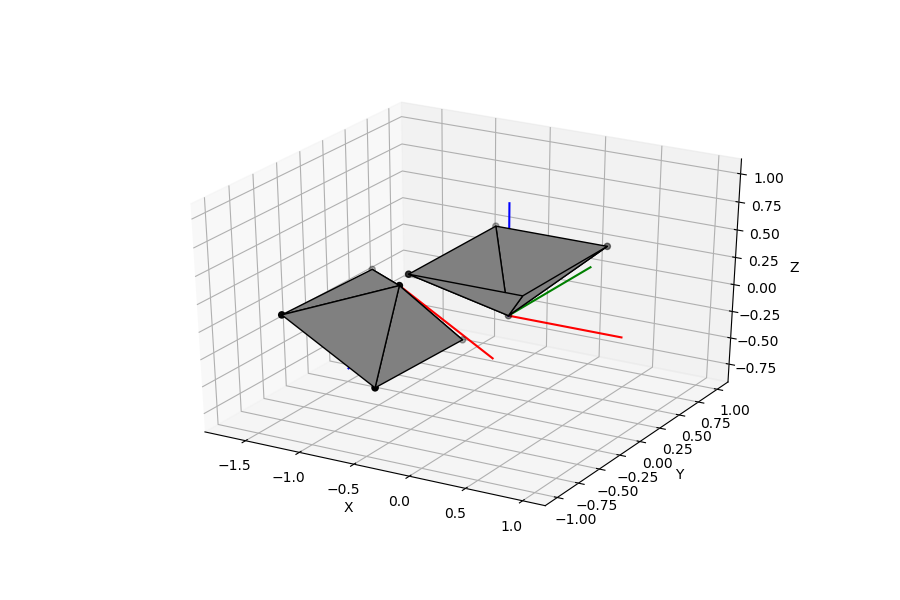

<IPython.core.display.Javascript object>


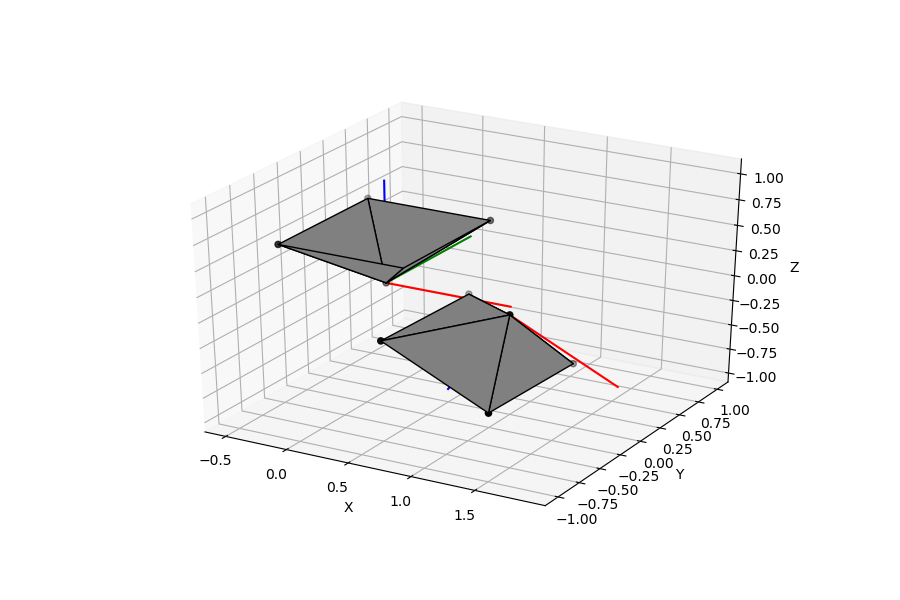

<IPython.core.display.Javascript object>


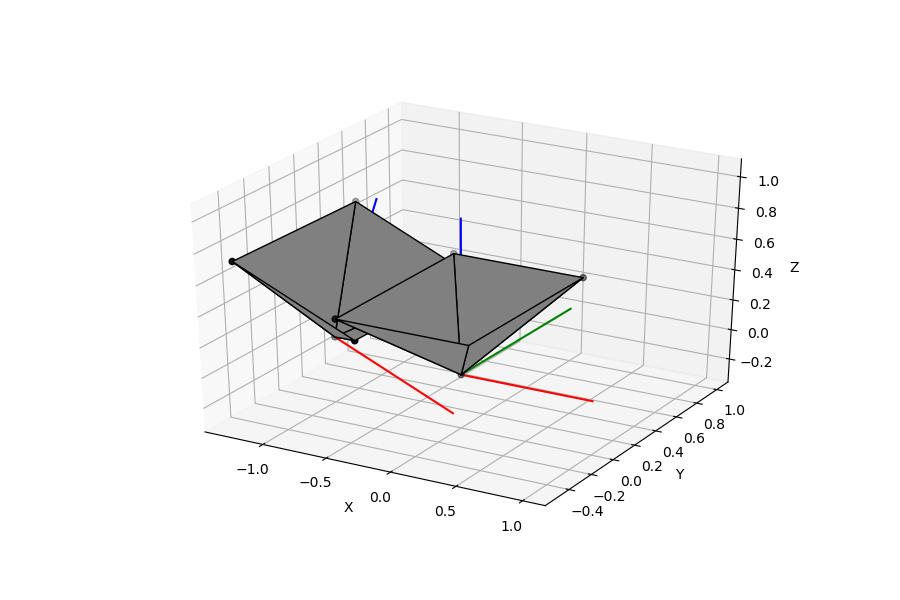

<IPython.core.display.Javascript object>


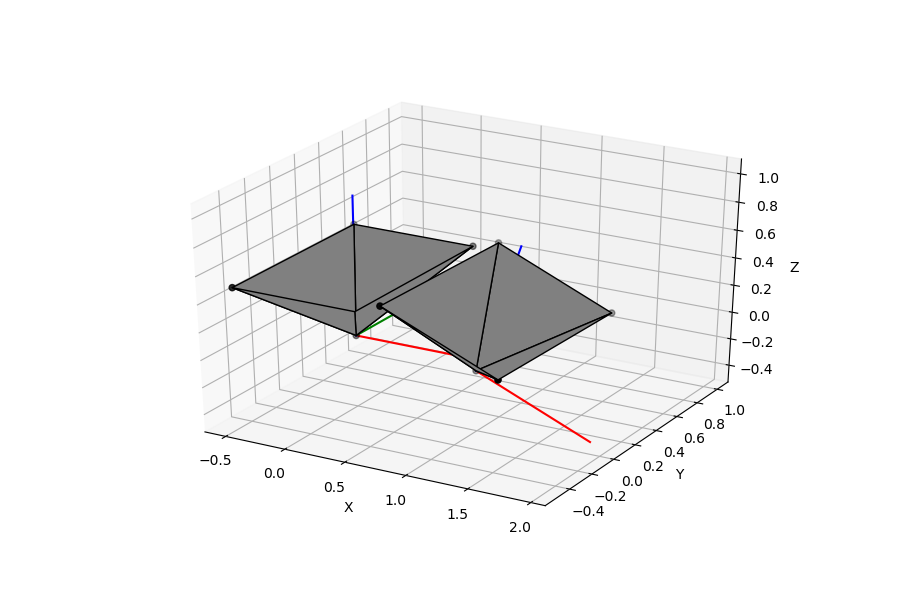

In [32]:
for R_ in [R1,R2]: 
    for t_ in [t,-t]:
        
        fig = plt.figure(figsize=(9,6))
        ax = fig.add_subplot(111, projection='3d')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')

        ut.PlotCamera(np.eye(3,3),np.zeros((3,)),ax)
        ut.PlotCamera(R_,t_[:,0],ax)

# Chapter 3. 3D Scene Estimations

## 3.1. Triangulation: DLT Method 

In [33]:
def GetTriangulatedPts(img1pts,img2pts,K,R,t,triangulateFunc): 
    img1ptsHom = cv2.convertPointsToHomogeneous(img1pts)[:,0,:]
    img2ptsHom = cv2.convertPointsToHomogeneous(img2pts)[:,0,:]

    img1ptsNorm = (np.linalg.inv(K).dot(img1ptsHom.T)).T
    img2ptsNorm = (np.linalg.inv(K).dot(img2ptsHom.T)).T

    img1ptsNorm = cv2.convertPointsFromHomogeneous(img1ptsNorm)[:,0,:]
    img2ptsNorm = cv2.convertPointsFromHomogeneous(img2ptsNorm)[:,0,:]
    
    pts4d = triangulateFunc(np.eye(3,4),np.hstack((R,t)),img1ptsNorm.T,img2ptsNorm.T)
    pts3d = cv2.convertPointsFromHomogeneous(pts4d.T)[:,0,:]
    
    return pts3d

In [34]:
pts3dgt = GetTriangulatedPts(img1pts[mask],img2pts[mask],K,R2,t,cv2.triangulatePoints)
pts3d = GetTriangulatedPts(img1pts[mask],img2pts[mask],K,R2,t,sfmnp.Triangulate)

In [35]:
print (pts3dgt[:5])
print 
print (pts3d[:5])
np.testing.assert_allclose(pts3d,pts3dgt,rtol=1e-7,atol=1e-3)

[[-1.19397057  0.51098989  2.51830959]
 [-1.20160245  0.23039112  2.57262085]
 [-1.18160098  0.44750795  2.56195649]
 [-1.16488478 -0.39880327  2.61574849]
 [-1.13840529 -0.24430035  2.61056407]]
[[-1.19573443  0.51201077  2.52415361]
 [-1.20157143  0.23039125  2.5725144 ]
 [-1.18269057  0.44802493  2.565706  ]
 [-1.16813564 -0.40020069  2.62708765]
 [-1.13998258 -0.24455384  2.61623673]]


AssertionError: 
Not equal to tolerance rtol=1e-07, atol=0.001

Mismatch: 58.7%
Max absolute difference: 0.02333627
Max relative difference: 0.08922204
 x: array([[-1.195734,  0.512011,  2.524154],
       [-1.201571,  0.230391,  2.572514],
       [-1.182691,  0.448025,  2.565706],...
 y: array([[-1.193971,  0.51099 ,  2.51831 ],
       [-1.201602,  0.230391,  2.572621],
       [-1.181601,  0.447508,  2.561956],...

In [36]:
configSet = [None,None,None,None]
configSet[0] = (R1,t,GetTriangulatedPts(img1pts[mask],img2pts[mask],K,R1,t,cv2.triangulatePoints))
configSet[1] = (R1,-t,GetTriangulatedPts(img1pts[mask],img2pts[mask],K,R1,-t,cv2.triangulatePoints))
configSet[2] = (R2,t,GetTriangulatedPts(img1pts[mask],img2pts[mask],K,R2,t,cv2.triangulatePoints))
configSet[3] = (R2,-t,GetTriangulatedPts(img1pts[mask],img2pts[mask],K,R2,-t,cv2.triangulatePoints))

## 3.2. Visualizing the triangulated points of configurations

<IPython.core.display.Javascript object>


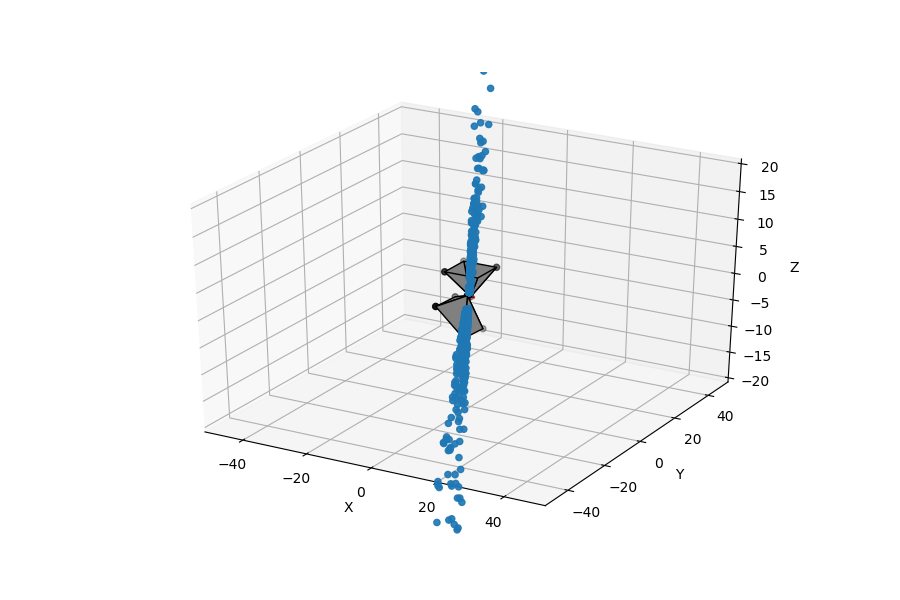

<IPython.core.display.Javascript object>


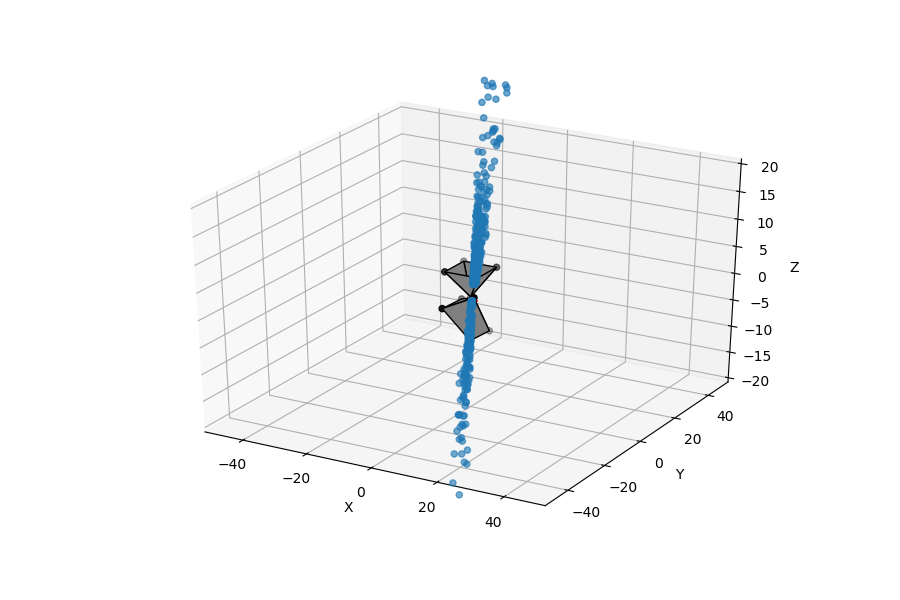

<IPython.core.display.Javascript object>


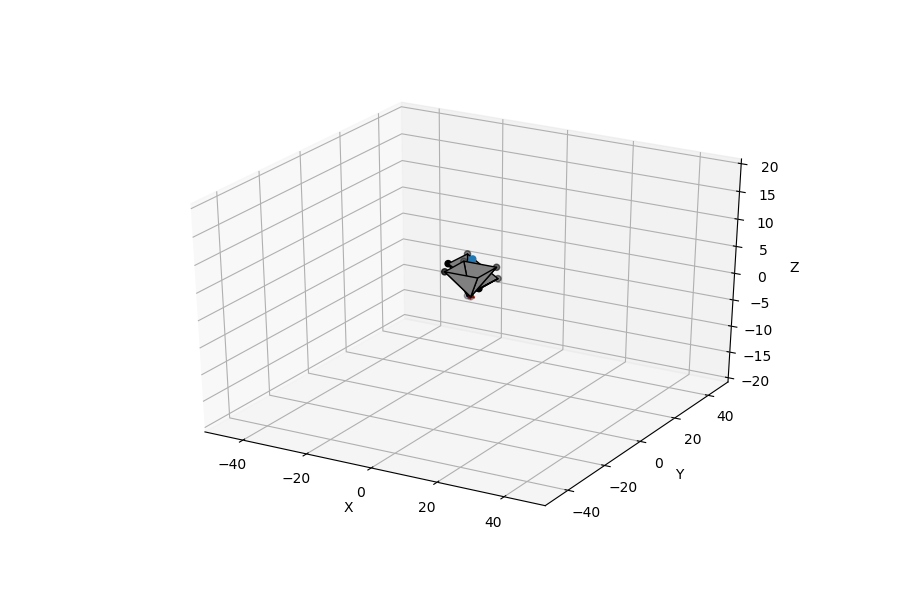

<IPython.core.display.Javascript object>


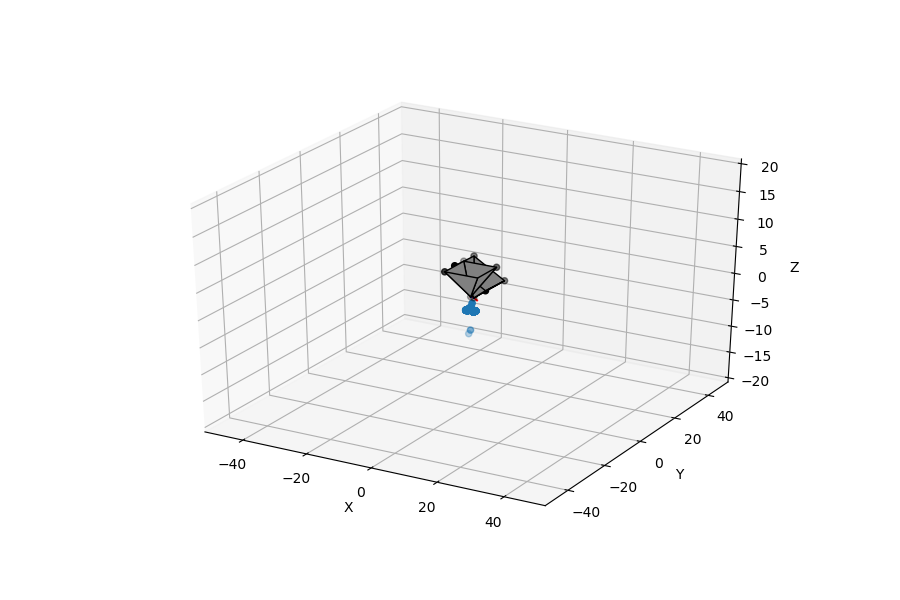

In [37]:
for cs in configSet: 
    fig = plt.figure(figsize=(9,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    ut.PlotCamera(np.eye(3,3),np.zeros((3,)),ax,scale=5,depth=5)
    ut.PlotCamera(cs[0],cs[1][:,0],ax,scale=5,depth=5)

    pts3d = cs[-1]
    ax.scatter3D(pts3d[:,0],pts3d[:,1],pts3d[:,2])

    ax.set_xlim(left=-50,right=50)
    ax.set_ylim(bottom=-50,top=50)
    ax.set_zlim(bottom=-20,top=20)

## 3.3. Camera Pose Disambiguation

In [38]:
_,Rgt,tgt,mask2=cv2.recoverPose(E,img1pts[mask],img2pts[mask],K)
R,t,count = sfmnp.DisambiguateCameraPose(configSet)

In [39]:
print (R)
print 
print (Rgt)
print 
print (t)
print 
print (tgt)

np.testing.assert_allclose(R,Rgt,rtol=1e-7,atol=1e-4)
np.testing.assert_allclose(t,tgt,rtol=1e-7,atol=1e-4)

[[ 0.93853385 -0.01294129 -0.34494455]
 [ 0.00834033  0.99985541 -0.01481901]
 [ 0.34508645  0.01103119  0.93850608]]
[[ 0.93853385 -0.01294129 -0.34494455]
 [ 0.00834033  0.99985541 -0.01481901]
 [ 0.34508645  0.01103119  0.93850608]]
[[ 0.99677533]
 [-0.0048716 ]
 [-0.080095  ]]
[[ 0.99677533]
 [-0.0048716 ]
 [-0.080095  ]]


## 3.4. Visualizing Point Cloud Output

Since point cloud isn't effectively viewed in matplotlib, we can use an external software `meshlab` for better visualizations. For that, we'd need to transform our 3D points' format into meshlab-compatible format. We understand it can be rather tedious, so the function `pts2ply()` is already implemented for you.

In [41]:
pts3d = GetTriangulatedPts(img1pts[mask],img2pts[mask],K,R,t,cv2.triangulatePoints)
ut.pts2ply(pts3d,'castle_2view.ply')

Now, please run `out.ply` with `meshlab` like so: `meshlab out.ply`

Output is also displayed below for reference

**NOTE**: Meshlab can be installed using `sudo apt-get install meshlab`

<img src="fountain.png">

# 3. Reprojection Error: Evaluation

## 3.1. Computation

In [42]:
img1ptsReproj = sfmnp.ComputeReprojections(pts3d,np.eye(3,3),np.zeros((3,1)),K)
img2ptsReproj = sfmnp.ComputeReprojections(pts3d,R,t,K)

In [43]:
err2 = sfmnp.ComputeReprojectionError(img2pts[mask], img2ptsReproj)
err1 = sfmnp.ComputeReprojectionError(img1pts[mask], img1ptsReproj)

err1, err2 

(20.11267876002, 21.625003318650418)

## 3.2. Visualizations

<IPython.core.display.Javascript object>


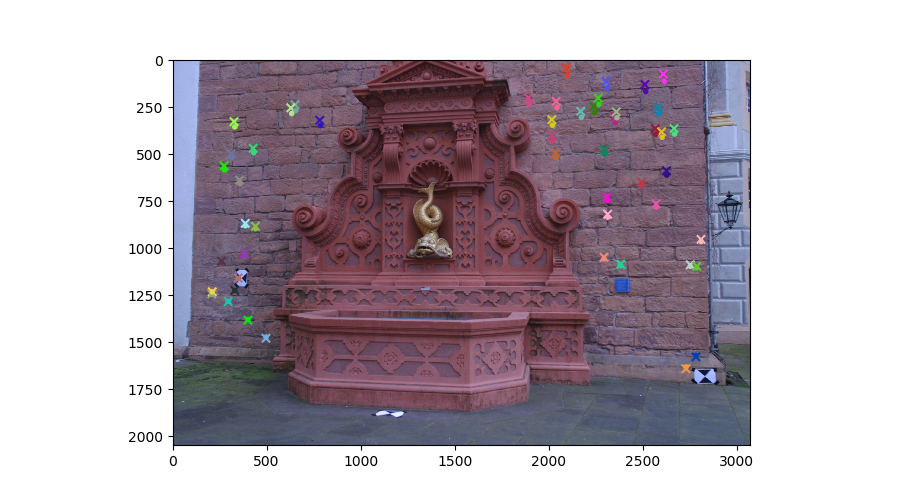

<IPython.core.display.Javascript object>


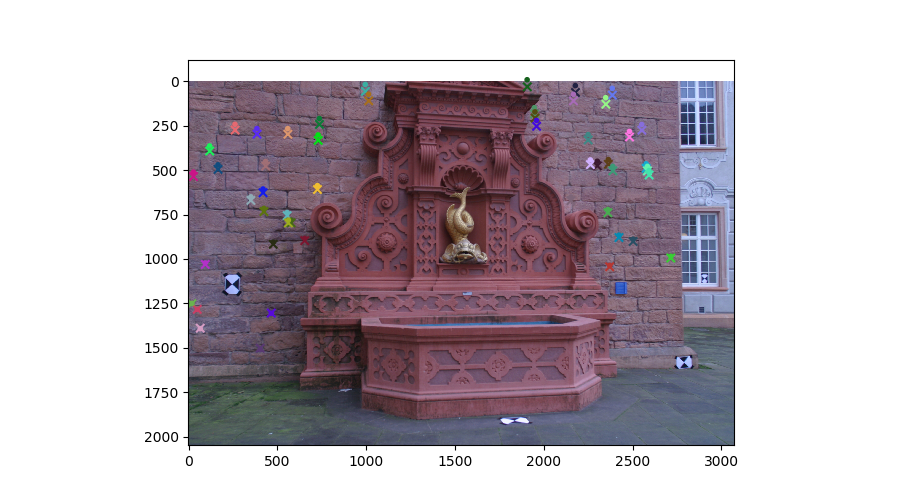

In [44]:
fig,ax=plt.subplots(figsize=(9,5))
ut.DrawCorrespondences(img1,img1pts[mask],img1ptsReproj,ax)

fig,ax=plt.subplots(figsize=(9,5))
ut.DrawCorrespondences(img2,img2pts[mask],img2ptsReproj,ax)

# 4. Perspective-n-Point Algorithm: New Camera Registration

## 4.0. Reading third image and 2D-3D Matching using SIFT

<IPython.core.display.Javascript object>


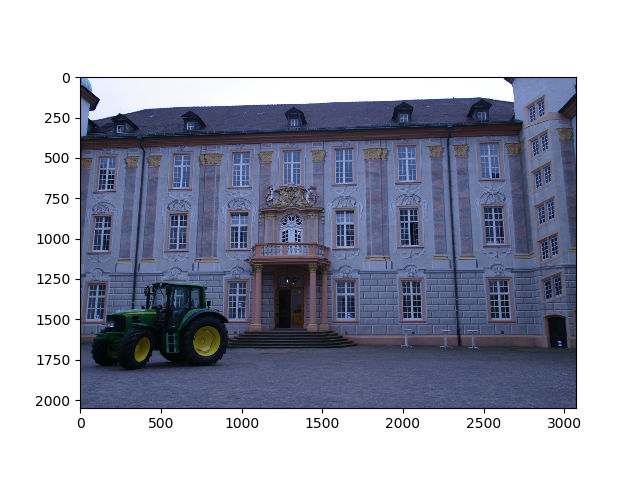

In [48]:
img3 = cv2.imread('../data/castle-P19/images/0006.jpg')
img3 = img3[:,:,::-1]
surfer=cv2.xfeatures2d.SURF_create()
kp3, desc3 = surfer.detectAndCompute(img3,None)

plt.figure()
plt.imshow(img3)

img3pts,pts3dpts = ut.Find2D3DMatches(desc1,img1idx,desc2,img2idx,desc3,kp3,mask,pts3d)

## 4.1. Perspective-n-Point (PnP) Algorithm

### 4.1.1. Least Squares Solution

### 4.1.2. RANSAC

In [49]:

from upenn_sfm_cache import LinearPnP
Rtest,ttest=LinearPnP(pts3dpts,img3pts,K)

In [50]:
retval,Rvec,tnew,mask3gt = cv2.solvePnPRansac(pts3dpts[:,np.newaxis],img3pts[:,np.newaxis],
                                            K,None,confidence=.99,flags=cv2.SOLVEPNP_DLS)
Rnew,_=cv2.Rodrigues(Rvec)

In [51]:
#Rnew,tnew,mask3=sfmnp.LinearPnPRansac(pts3dpts,img3pts,K,outlierThres=5.0,iters=2000)

In [52]:
tnew = tnew[:,0]

## 4.2. Visualizations

<IPython.core.display.Javascript object>


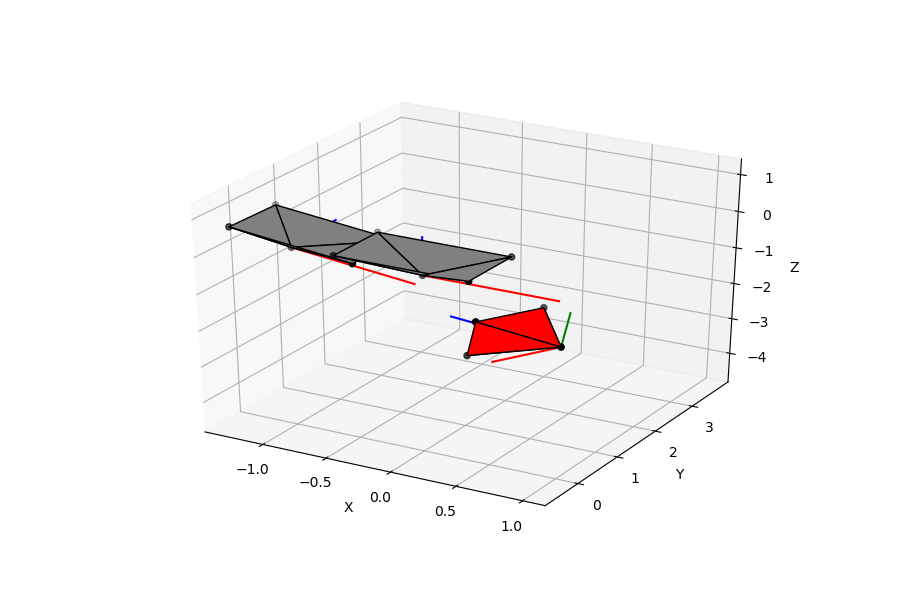

In [53]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# print("R \n", R)
# print("T \n", t)
# print("Rn \n", Rnew)
# print("Tn \n",  tnew.shape)

ut.PlotCamera(np.eye(3,3),np.zeros((3,)),ax)
ut.PlotCamera(R,t[:,0],ax)
#ut.PlotCamera(Rnew,tnew.reshape[:,0],ax,faceColor='red')
ut.PlotCamera(Rnew,tnew.reshape((3,1))[:,0],ax,faceColor='red')# commented by Tan

# 5. Re-triangulation

In [54]:
kpNew, descNew = kp3, desc3 

kpOld,descOld = kp1,desc1
ROld, tOld = np.eye(3), np.zeros((3,1))

accPts = []
for (ROld, tOld, kpOld, descOld) in [(np.eye(3),np.zeros((3,1)), kp1,desc1),(R,t,kp2,desc2)]: 
    
    #Matching between old view and newly registered view.. 
    print ('[Info]: Feature Matching..')
    matcher = cv2.BFMatcher(crossCheck=True)
    matches = matcher.match(descOld, desc3)
    matches = sorted(matches, key = lambda x:x.distance)
    imgOldPts, imgNewPts, _, _ = ut.GetAlignedMatches(kpOld,descOld,kpNew,
                                                          descNew,matches)
    
    #Pruning the matches using fundamental matrix..
    print ('[Info]: Pruning the Matches..')
    #F,mask=cv2.findFundamentalMat(imgOldPts,imgNewPts,method=cv2.FM_RANSAC,param1=.1,param2=.99)
    F,mask=cv2.findFundamentalMat(imgOldPts,imgNewPts,method=cv2.FM_RANSAC)

    mask = mask.flatten().astype(bool)
    imgOldPts=imgOldPts[mask]
    imgNewPts=imgNewPts[mask]
    
    #Triangulating new points
    print ('[Info]: Triangulating..')
    newPts = sfmnp.GetTriangulatedPts(imgOldPts,imgNewPts, K, Rnew,tnew[:,np.newaxis],cv2.triangulatePoints,ROld,tOld)
    
    #Adding newly triangulated points to the collection
    accPts.append(newPts)

[Info]: Feature Matching..
[Info]: Pruning the Matches..
[Info]: Triangulating..
(3, 3) (3, 1) (3, 3) (3, 1)
[Info]: Feature Matching..
[Info]: Pruning the Matches..
[Info]: Triangulating..
(3, 3) (3, 1) (3, 3) (3, 1)


In [55]:
#Adding the original 2-view-sfm point cloud and saving the whole collection
accPts.append(pts3d)
ut.pts2ply(np.concatenate((accPts),axis=0),'castle_nview.ply')

# 6. Final Result 

<img src="fountain_dense.png">

# Chapter 4. Putting It Together: Part I

# Chapter 5. Bundle Adjustment

# Chapter 6. Putting It Together: Part II

In [56]:

lc=np.zeros((2,1))
a=20 
b=10
corrl=np.hstack((lc,np.array([[a],[b]])))
lc=corrl
a=150 
b=100
corrl=np.hstack((lc,np.array([[a],[b]])))
print(corrl)

g= corrl[:,1:]
print("g",g)


[[  0.  20. 150.]
 [  0.  10. 100.]]
g [[ 20. 150.]
 [ 10. 100.]]


In [57]:
import math
def deg2rad(deg): 
    return deg * (math.pi/180)
f_inv = 298.257224
#f = 1.0 / f_inv
f = 0.0 # here we considered ideal earth shape
e2 = 1 - (1 - f) * (1 - f)
altitude=4.281411


def get_cartesian(latitude=None,longitude=None,altitude=0.0):
    R = 6378137 #radius in meter
    #R = 6371000
    cosLat = math.cos(latitude * math.pi / 180)
    sinLat = math.sin(latitude * math.pi / 180)

    cosLong = math.cos(longitude * math.pi / 180)
    sinLong = math.sin(longitude * math.pi / 180)

    c = 1 / math.sqrt(cosLat * cosLat + (1 - f) * (1 - f) * sinLat * sinLat)
    s = (1 - f) * (1 - f) * c

    x = (R*c + altitude) * cosLat * cosLong
    y = (R*c + altitude) * cosLat * sinLong
    z = (R*s + altitude) * sinLat
    return [x,y,z]
'''
def get_cartesian(lat=None,lon=None):
    lat, lon = np.deg2rad(lat), np.deg2rad(lon)
    R = 6371000 # radius of the earth
    x = R * np.cos(lat) * np.cos(lon)
    y = R * np.cos(lat) * np.sin(lon)
    z = R *np.sin(lat)
    return [x,y,z]
'''
def get_latlon(X=None,Y=None,Z=None):
    R = 6378137
    #R = 6371000
    lat = math.degrees(math.asin(Z/R))
    lon = math.degrees(math.atan2(Y,X))
    return[lat,lon]

prince_gps=[41.333317727121900,-74.190944277933500,41.333354457942900,-74.191021643789500]
cart=get_cartesian(prince_gps[0],prince_gps[1])
print("cart",cart)
cart[0]=cart[0]+0 #left of vehicle +
cart[1]=cart[1]+500
cart[2]=cart[2]+0
print("\n cart modified",cart)
gps=get_latlon(cart[0],cart[1],cart[2])
print("\n gps",gps)

cart [1304737.4828948784, -4608064.486548225, 4212366.719471511]

 cart modified [1304737.4828948784, -4607564.486548225, 4212366.719471511]

 gps [41.333317727121916, -74.18931449263167]


In [58]:
# Rough code 
import argparse
import cv2
import numpy as np
# def build_arg_parser():
# parser = argparse.ArgumentParser(description='Reconstruct the 3D map from \ the two input stereo images.
# Output will be saved in \'output.ply\'')
# parser.add_argument("--image-left", dest="image_left", required=True,
# help="Input image captured from the left")
# parser.add_argument("--image-right", dest="image_right", required=True,
# help="Input image captured from the right")
# parser.add_argument("--output-file", dest="output_file", required=True,
# help="Output filename (without the extension) where the point cloud will be saved")
# return parser

class build_arg_parser:
    
    print('Hello, how are you?')
    image_left="testL.jpg"
    image_right="testR.jpg"
    output_file="output"

def create_output(vertices, colors, filename):
    colors = colors.reshape(-1, 3)
    vertices = np.hstack([vertices.reshape(-1,3), colors])
    ply_header = '''ply
    format ascii 1.0
    element vertex %(vert_num)d
    property float x
    property float y
    property float z
    property uchar red
    property uchar green
    property uchar blue
    end_header
    '''

    with open(filename, 'w') as f:
        f.write(ply_header % dict(vert_num=len(vertices)))
        np.savetxt(f, vertices, '%f %f %f %d %d %d')
        
if __name__ == '__main__':
    args = build_arg_parser()
    image_left = cv2.imread(args.image_left)
    image_right = cv2.imread(args.image_right)
    output_file = args.output_file + '.ply'
    if image_left.shape[0] != image_right.shape[0] or \
        image_left.shape[1] != image_right.shape[1]:
        raise TypeError("Input images must be of the same size")
# downscale images for faster processing
    image_left = cv2.pyrDown(image_left)
    image_right = cv2.pyrDown(image_right)
    
# disparity range is tuned for 'aloe' image pair
    win_size = 1
    min_disp = 16
    max_disp = min_disp * 9
    num_disp = max_disp - min_disp # Needs to be divisible by 16
    stereo = cv2.StereoSGBM_create(minDisparity = min_disp,
    numDisparities = num_disp,
    uniquenessRatio = 10,
    speckleWindowSize = 100,
    speckleRange = 32,
    disp12MaxDiff = 1,
    P1 = 8*3*win_size**2,
    P2 = 32*3*win_size**2,
    )
    #cv2.StereoBM(cv2.STEREO_BM_BASIC_PRESET,ndisparities=16, SADWindowSize=15)
    #disparity = stereo.compute(imgL,imgR)
    print( "\nComputing the disparity map…")
    disparity_map = stereo.compute(image_left,image_right).astype(np.float32) / 16.0
    print ("\nGenerating the 3D map…")
    h, w = image_left.shape[:2]
    focal_length = 0.8*w
# Perspective transformation matrix
    Q = np.float32([[1, 0, 0, -w/2.0],
    [0,-1, 0, h/2.0],
    [0, 0, 0, -focal_length],
    [0, 0, 1, 0]])
    points_3D = cv2.reprojectImageTo3D(disparity_map, Q)
    colors = cv2.cvtColor(image_left, cv2.COLOR_BGR2RGB)
    mask_map = disparity_map > disparity_map.min()
    output_points = points_3D[mask_map]
    output_colors = colors[mask_map]
    print ("\nCreating the output file…\n")
    create_output(output_points, output_colors, output_file)


Hello, how are you?


TypeError: Required argument 'blockSize' (pos 3) not found

In [25]:
a=np.ones((4,4))
c=np.repeat(a[:, 3], 3)
b=np.repeat(a[:, 3], 3).reshape(-1, 3)
print(c)
print(b)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]
